# Rede neural 65622
Melhor desempenho considerando o critério de maior cos_sim e menor loss 

In [1]:
# Importando as bibliotecas necessarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
pd.set_option("display.max_rows", 300)

D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type

In [2]:
class Net(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(Net, self).__init__()
        self.num_layers = num_layers

        self.linears = nn.ModuleList([nn.Linear(input_size, layers_size[0])])
        for i in range(0, self.num_layers-2):
            self.linears.extend([nn.Linear(layers_size[i], layers_size[i+1])])              
        self.linears.append(nn.Linear(layers_size[-1], output_size))

    def forward(self, x):
        for layer in self.linears[0:-1]:                   
            x = torch.tanh(layer(x))
        x = self.linears[-1](x)
        return(x)

In [3]:
testes = pd.read_csv("Loop_Testes_Regressao2.csv")
rede = testes.iloc[np.where(testes["index"]==65622)]
rede

,index,net_param,ncamadas,n_features,features_col,features_name,random_state,data_train,data_train_resample,test_loss,test_cos_sim,net
15622,65622.0,<bound method Module.parameters of Net(\r\n (...,6,18,[ 1 15 41 49 52 58 86 89 94 97 99 1...,"['AgeGroup', 'Analgesic', 'Diabetesmellitus', ...",77,124,280,0.04118,0.873746,net_65622


In [4]:
print(rede.iloc[0,1])

<bound method Module.parameters of Net(
  (linears): ModuleList(
    (0): Linear(in_features=18, out_features=12, bias=True)
    (1): Linear(in_features=12, out_features=9, bias=True)
    (2): Linear(in_features=9, out_features=6, bias=True)
    (3): Linear(in_features=6, out_features=3, bias=True)
    (4): Linear(in_features=3, out_features=1, bias=True)
    (5): Linear(in_features=1, out_features=1, bias=True)
  )
)>


Numero de features: 18
Colunas:  [1, 15, 41, 49, 52, 58, 86, 89, 94, 97, 99, 111, 117, 123, 135, 152, 167, 173]
Features:  ['AgeGroup', 'Analgesic', 'Diabetesmellitus', 'Hblocker', 'Hypercholesterolemia', 'Meglitinide', 'Epilepsy', 'Fatty liver', 'Hiatus hernia', 'Inflammation of the tibial nerve', 'Kidney failure', 'Sickle cell anemia', 'Varicose veins of the legs', 'Depression', 'Vasovagal syncope', 'Hypothyroidism_total', 'Internal fixation in the leg', 'PaceMaker']
Random State: 77
Histogramas dos dados de treino


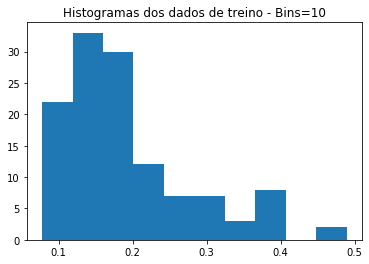

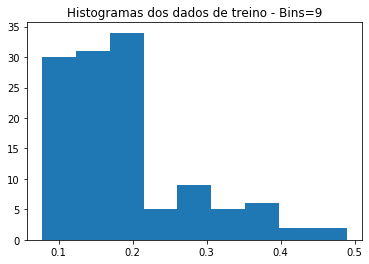

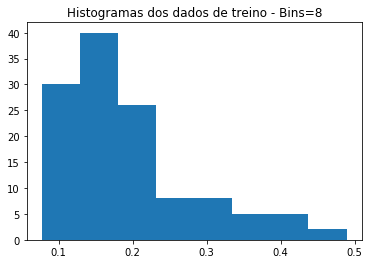

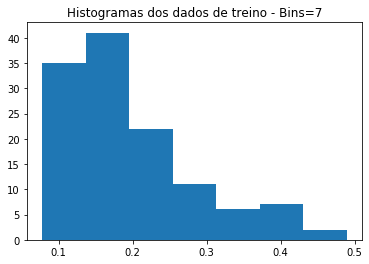

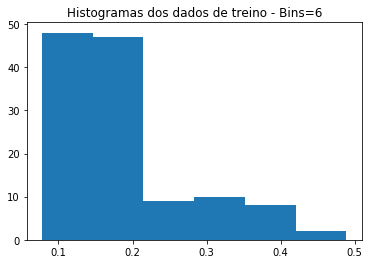

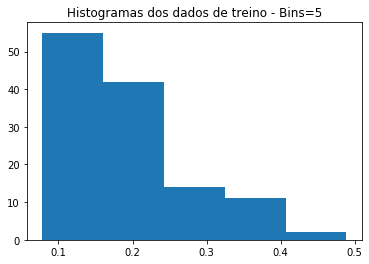

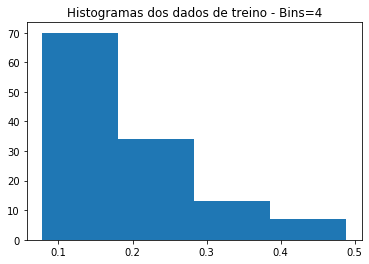

Data train: 124
Data train resample: 280
Histograma dos dados de treino com Resample SMOTE


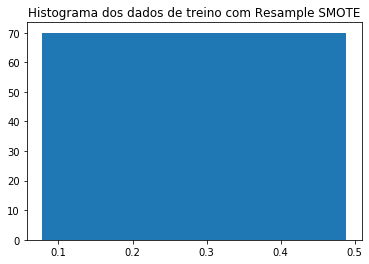

Number of layers: 6
Inicial size layer: 12
Layers sizes: [12, 9, 6, 3, 1]


In [5]:
data = pd.read_pickle("data_closed_rigid_o")
pf50 = data["PF50_closed_rigid"].values

# Sortear quais caracteristicas usar
n_features = rede.iloc[0,3]
print('Numero de features: %d' % (n_features))
columns =   [1, 15, 41, 49, 52, 58, 86, 89, 94, 97, 99, 111, 117, 123, 135, 152, 167, 173]
print('Colunas: ',columns)

features = data.iloc[:,columns]
features_names = features.columns
print('Features: ',list(features_names))
X = features.values
y = pf50.reshape(len(pf50), 1)

# Separando o dataset em treino e teste
random_state = rede.iloc[0,6]
print('Random State: %d' % (random_state))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

# Histograma dos dados de treino
print("Histogramas dos dados de treino")
for nbins in range(10,1,-1):
    n, bins, patches = plt.hist(y_train, nbins)
    plt.title("Histogramas dos dados de treino - Bins="+str(nbins))
    plt.show()
    if np.min(n)>3:
        break
        
# Indica qual o bin correspondente para cada dado
indices = np.digitize(y_train, bins)

# Arrumar o caso do último valor que não é incluído no último bin
indices[indices>nbins]=nbins
indices = indices.reshape(len(indices),)

# SMOTE - Data Augmentation
data_train = np.hstack([X_train, y_train])
print('Data train: %d' % (data_train.shape[0]))
sm = SMOTE(k_neighbors=np.int(n.min()-1), random_state=42)
data_train_res, indices_res = sm.fit_resample(data_train, indices)
print('Data train resample: %d' % (data_train_res.shape[0]))

# Histograma dos dados de treino resample
print("Histograma dos dados de treino com Resample SMOTE")
n_res, bins_res, patches_res = plt.hist(data_train_res[:,-1], nbins)
plt.title("Histograma dos dados de treino com Resample SMOTE")
plt.show()

# Declarando o dado resample como dado de treino
X_train = data_train_res[:,0:-1]
y_train = data_train_res[:,-1].reshape(data_train_res.shape[0],1)

# Ajustando o escalamento ao dado de TREINAMENTO (fit) e transformando o dado de treinamento
scaler_x = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_x.fit_transform(X_train)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)

torch.manual_seed(1234)

num_layers = rede.iloc[0,2]
print('Number of layers: %d' % (num_layers))
layer_init_size = 12
print('Inicial size layer: %d' % (layer_init_size))
layers_size = np.linspace(layer_init_size, 1, num_layers-1, dtype=int)
print('Layers sizes:', list(layers_size))

net = Net(input_size=X.shape[1], num_layers=num_layers, layers_size=layers_size , output_size=1)


In [6]:
# Choose optmizer and loss function
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.05, momentum = 0.9) # lr = learning rate

# Treinamento utilizando o dado de treino transformado
epochs = 5000
lossr = np.zeros(epochs)

for epoch in range(epochs):
    inputs = torch.autograd.Variable(torch.Tensor(X_train_scaled.astype(np.float32)).float())
    targets = torch.autograd.Variable(torch.Tensor(y_train_scaled.astype(np.float32)).float())

    optimizer.zero_grad()
    out = net(inputs)
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()

    lossr[epoch] = loss.item()

    if epoch == 0 or (epoch + 1) % 10 == 0:
        print('Epoch %d Loss: %.4f' % (epoch + 1, loss.item()))


Epoch 1 Loss: 2.1708
Epoch 10 Loss: 0.1199
Epoch 20 Loss: 0.1741
Epoch 30 Loss: 0.0933
Epoch 40 Loss: 0.0827
Epoch 50 Loss: 0.0788
Epoch 60 Loss: 0.0755
Epoch 70 Loss: 0.0757
Epoch 80 Loss: 0.0751
Epoch 90 Loss: 0.0752
Epoch 100 Loss: 0.0751
Epoch 110 Loss: 0.0751
Epoch 120 Loss: 0.0751
Epoch 130 Loss: 0.0751
Epoch 140 Loss: 0.0751
Epoch 150 Loss: 0.0751
Epoch 160 Loss: 0.0751
Epoch 170 Loss: 0.0751
Epoch 180 Loss: 0.0751
Epoch 190 Loss: 0.0751
Epoch 200 Loss: 0.0751
Epoch 210 Loss: 0.0751
Epoch 220 Loss: 0.0751
Epoch 230 Loss: 0.0751
Epoch 240 Loss: 0.0751
Epoch 250 Loss: 0.0751
Epoch 260 Loss: 0.0751
Epoch 270 Loss: 0.0751
Epoch 280 Loss: 0.0751
Epoch 290 Loss: 0.0751
Epoch 300 Loss: 0.0751
Epoch 310 Loss: 0.0751
Epoch 320 Loss: 0.0751
Epoch 330 Loss: 0.0751
Epoch 340 Loss: 0.0751
Epoch 350 Loss: 0.0751
Epoch 360 Loss: 0.0751
Epoch 370 Loss: 0.0751
Epoch 380 Loss: 0.0751
Epoch 390 Loss: 0.0751
Epoch 400 Loss: 0.0751
Epoch 410 Loss: 0.0751
Epoch 420 Loss: 0.0751
Epoch 430 Loss: 0.0751

Epoch 3490 Loss: 0.0748
Epoch 3500 Loss: 0.0747
Epoch 3510 Loss: 0.0747
Epoch 3520 Loss: 0.0747
Epoch 3530 Loss: 0.0747
Epoch 3540 Loss: 0.0746
Epoch 3550 Loss: 0.0746
Epoch 3560 Loss: 0.0746
Epoch 3570 Loss: 0.0745
Epoch 3580 Loss: 0.0745
Epoch 3590 Loss: 0.0744
Epoch 3600 Loss: 0.0744
Epoch 3610 Loss: 0.0743
Epoch 3620 Loss: 0.0742
Epoch 3630 Loss: 0.0741
Epoch 3640 Loss: 0.0739
Epoch 3650 Loss: 0.0737
Epoch 3660 Loss: 0.0735
Epoch 3670 Loss: 0.0731
Epoch 3680 Loss: 0.0726
Epoch 3690 Loss: 0.0719
Epoch 3700 Loss: 0.0708
Epoch 3710 Loss: 0.0691
Epoch 3720 Loss: 0.0668
Epoch 3730 Loss: 0.0646
Epoch 3740 Loss: 0.0635
Epoch 3750 Loss: 0.0633
Epoch 3760 Loss: 0.0631
Epoch 3770 Loss: 0.0628
Epoch 3780 Loss: 0.0626
Epoch 3790 Loss: 0.0624
Epoch 3800 Loss: 0.0622
Epoch 3810 Loss: 0.0621
Epoch 3820 Loss: 0.0619
Epoch 3830 Loss: 0.0617
Epoch 3840 Loss: 0.0615
Epoch 3850 Loss: 0.0613
Epoch 3860 Loss: 0.0611
Epoch 3870 Loss: 0.0609
Epoch 3880 Loss: 0.0607
Epoch 3890 Loss: 0.0605
Epoch 3900 Loss:

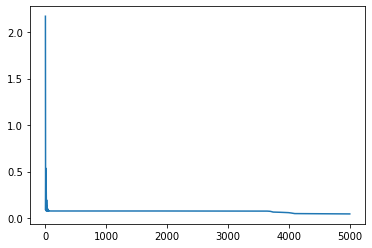

Teste Loss: 0.0412
Teste Cosine Similarity: 0.8737


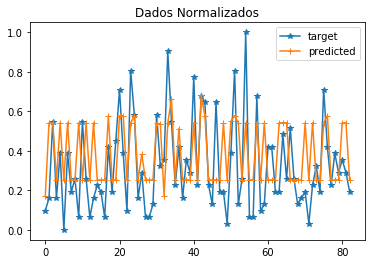

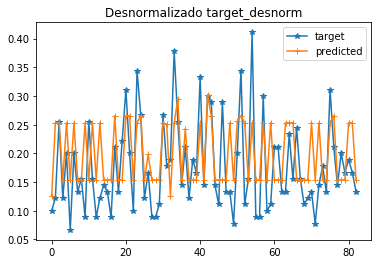

In [7]:
epoch = np.arange(0, epochs)
plt.plot(epoch,lossr)
plt.show()

# Transformando o dado de teste
X_test_scaled = scaler_x.fit_transform(X_test)
y_test_scaled = scaler_y.fit_transform(y_test)

# Avaliando a acurácia do modelo utilizando os dados de teste transformados
inputs = torch.autograd.Variable(torch.Tensor(X_test_scaled.astype(np.float32)).float())
targets = torch.autograd.Variable(torch.Tensor(y_test_scaled.astype(np.float32)).float())

optimizer.zero_grad()
out = net(inputs)
loss = criterion(out, targets)
loss.backward()
optimizer.step()

predicted = out.data

print('Teste Loss: %.4f' % (loss.item()))

# Implementando a métrica do Cosine Similarity
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
cos_sim = cos(targets, predicted)
print('Teste Cosine Similarity: %.4f' % (cos_sim.item()))

ninput = np.arange(len(X_test))
plt.figure()
plt.plot(ninput, y_test_scaled, '-*', label = 'target')
plt.plot(ninput, predicted.numpy(), '-+', label = 'predicted')
plt.title('Dados Normalizados')
plt.legend()
plt.show()

# Fazendo a transformação inversa para desnormalizar o dado de teste
predicted_desnorm = scaler_y.inverse_transform(predicted.numpy())
target_desnorm = scaler_y.inverse_transform(y_test_scaled)

plt.figure()
plt.plot(ninput, target_desnorm, '-*', label = 'target')
plt.plot(ninput, predicted_desnorm, '-+', label = 'predicted')
plt.title('Desnormalizado target_desnorm')
plt.legend()
plt.show()

D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


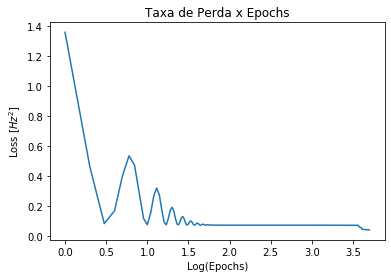

In [8]:
plt.figure()
plt.plot(np.log10(epoch),lossr)
plt.title("Taxa de Perda x Epochs")
plt.xlabel("Log(Epochs)")
plt.ylabel("Loss [$Hz^2$]")
plt.show()

## Pela análise dos gráficos, pode-se perceber que a rede atingiu dois níveis (valores extremos).
## Próximos passos:
- Mudar a função de ativação (tanh para relu)